## Loading up packages

In [119]:
# import plastid
# data structure for mapping read alignments to genomic positions
from plastid import BAMGenomeArray, VariableFivePrimeMapFactory, \
                        GTF2_TranscriptAssembler, GFF3_TranscriptAssembler, \
                        Transcript, ThreePrimeMapFactory
import numpy as np
from Bio import SeqIO
import numpy
import pandas as pd
%matplotlib inline
import warnings
import matplotlib.pyplot as plt
import csv
from scipy.sparse.linalg import lsqr

In [53]:
# Define the path to our Bam files
data_path = '/home/keeganfl/Desktop/Work_Fall_2021/genomes_&_samples/dmel/'
position_count_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/position_counts/dmel/'
te_table_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/TE_tables/dmel/'

## Defining Functions

In [54]:
def variable_threeprime_map_function(alignments,segment,p_offsets):
        '''
        This function is used to map read alignments to the location of the ribosomal p-site 
        from their 3' end. The offsets to use for each read length are specified by file
        generated using RiboWaltz.

        alignments:
            Information on the genome alignment of an individual read which is passed 
            to the function from a BamGenome array created by plastid. 

        segment:
            Information on the individual read segment which is passed 
            to the function from a BamGenome array created by plastid. 

        p_offsets:
            A pandas dataframe that has been loaded into the python environmemt.
            This dataframe should follow this template. 
                length          P_offsets
                 28              12
                 29              12
                 30              13
                ...             ...

        '''
        reads_out = []
        count_array = numpy.zeros(len(segment))
        for read in alignments: 
            for length, offset in zip(p_offsets["length"],p_offsets["p_offset"]): 
                if length != len(read.positions):
                    continue # skip read if it is not the length we are currently offsetting.

             # count offset 3' to 5' if the `segment` is on the plus-strand
             # or is unstranded
                if segment.strand == "+":
                    p_site = read.positions[-offset - 1]
                elif segment.strand == ".":
                    p_site = read.positions[-offset - 1]
             # count offset from other end if `segment` is on the minus-strand
                elif segment.strand == "-":
                    p_site = read.positions[offset]

                if p_site >= segment.start and p_site < segment.end:
                    reads_out.append(read)
                    count_array[p_site - segment.start] += 1
        return reads_out, count_array

In [55]:
def VariableThreePrimeMapFactory(p_offsets):
    '''
    BamGenome array objects will only be able to pass the alignments and segment
    arguments to the variable_threeprime_map_function. This wrapper allows me to
    also specify the offset that needs to be passed to the function. 
    '''
    def new_func(alignments,segment):
        return variable_threeprime_map_function(alignments,segment,p_offsets=p_offsets)

    return new_func

In [56]:
# Create a function that finds the proteins I need. 
def find_transcript(gene,transcripts, count_vectors):
    '''
    A function that takes the name of a gene as input and finds 
    the corresponding transcript from a transcript list. 
    
    returns both the transcript in question and the vector of counts for that transcript.
    
    This function is still a work in progress as for now it simply gives the last 
    transcript in the list that matches the gene ID. 
    '''
    for i in transcripts:
        if i.attr['transcript_biotype'] == 'protein_coding':
            if i.attr['gene_name'] == gene:
                my_transcript = i
                index = transcripts.index(i)
                my_vector = count_vectors[transcripts.index(i)]
                
    return my_transcript, my_vector, index

In [57]:
def find_max_list(list):
    ''' 
    A function that finds the longest list/array in a list of lists. 
    '''
    list_len = [len(i) for i in list]
    return(max(list_len))

## Loading up the data files 

In [58]:
# load the transcript annotations from the GTF file.
# GTF2_TranscriptAssembler returns an iterator, so here we convert it to a list.
transcripts = list(GTF2_TranscriptAssembler(open(data_path + "Drosophila_melanogaster.BDGP6.32.103.gtf"),return_type=Transcript))

In [59]:
# Remove non-protein coding transcripts from transcripts list. 
protein_coding = []
for transcript in transcripts:
    if transcript.attr['gene_biotype'] == 'protein_coding':
        protein_coding.append(transcript)

In [60]:
# clear up some memory by deleting original transcript list
transcripts.clear()

# Loading up the position counts file.

In [61]:
# Read in data row by row.
data = []
with open(position_count_path + "Fmr1_RPF_2_counts.csv", newline = '') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        data.append(row)

In [62]:
# Pop out the header row.
blank=data.pop(0)

In [63]:
# convert everything to an integer if possible. 
for i,ii in zip(data, range(len(data))):
    for j,jj in zip(i, range(len(i))):
        try:
            x = int(float(j))
            data[ii][jj] = x
        except:
            pass

In [64]:
# Remove empty space
for i,ii in zip(data, range(len(data))):
    x = list(filter(('').__ne__, i))
    data[ii] = x

In [65]:
# Convert lists to np.arrays
for i,ii in zip(data, range(len(data))):
    data[ii] = np.array(data[ii][2:])

## Loading up the TE table

In [67]:
te_table = pd.read_csv(te_table_path + "FMR1_2_te_table.csv")

## Getting the codon sequence:

If get.sequence returns the entire sequence, then it should be fairly simple to just index it with the numbers returned by get_cds stop and end so that I only have to look at the coding regions... Now how am I going to read through this such that each codon gets its own little name? 

Perhaps I should consider trying to run biopython in such a way that I do not have to save it into it's own dictionary like this.

In [68]:
genome = SeqIO.to_dict(SeqIO.parse(
    open(data_path + "Drosophila_melanogaster.BDGP6.32.cds.all.fa"),"fasta"))
# Using this cds file leads to everything being in 

In [69]:
cds_sequence=[]

for transcript in protein_coding:
    t_id = transcript.attr["transcript_id"]
    cds_sequence.append(str(genome[t_id].seq))

In [70]:
cd_dict = {'TTT':0,'TTC':1,'TTG':2,'TTA':3,
          'TCT':4,'TCC':5,'TCG':6,'TCA':7,
          'TGT':8,'TGC':9,'TGG':10,'TGA':11,
          'TAT':12,'TAC':13,'TAG':14,'TAA':15,
          'CTT':16,'CTC':17,'CTG':18,'CTA':19,
          'CCT':20,'CCC':21,'CCG':22,'CCA':23,
          'CGT':24,'CGC':25,'CGG':26,'CGA':27,
          'CAT':28,'CAC':29,'CAG':30,'CAA':31,
          'GTT':32,'GTC':33,'GTG':34,'GTA':35,
          'GCT':36,'GCC':37,'GCG':38,'GCA':39,
          'GGT':40,'GGC':41,'GGG':42,'GGA':43,
          'GAT':44,'GAC':45,'GAG':46,'GAA':47,
          'ATT':48,'ATC':49,'ATG':50,'ATA':51,
          'ACT':52,'ACC':53,'ACG':54,'ACA':55,
          'AGT':56,'AGC':57,'AGG':58,'AGA':59,
          'AAT':60,'AAC':61,'AAG':62,'AAA':63}

In [71]:
codon_seq_list = []

for seq in cds_sequence:
    codon_seq = []
    for i in range(0, len(seq), 3):
        try:
            codon_seq.append(cd_dict[seq[i:i+3]])
        except:
            pass
    codon_seq_list.append(codon_seq)

ok... I think i need to use the except pass thing because some of the coding sequences is not quite a multiple of three. I need to change that try, except, pass so that it gives me information on the gene in questions whenever it comes up. 

## Calculating Elongation rates

In [166]:
save_path = "/home/keeganfl/Desktop/Work_Fall_2021/EGGTART/"

In [167]:
my_gene = "lost"

In [168]:
# Choosing a gene of interest to calculate the elongation rates of. 
#Get the transcript and vector for the gene of interest
my_transcript, my_vector, index = find_transcript(my_gene, 
                                           protein_coding, data)

In [177]:
# choosing the
pi = te_table["TE_tpm"][te_table["gene_ID"] == my_gene]*0.00289

In [178]:
pi.values

array([0.00353227])

In [179]:
# Add one to every point in my vector to create a new baseline
my_vector = my_vector+1

In [180]:
# calculate the normalized profile (p) of my vector of interest

M = sum(my_vector)
p = (my_vector/M)*float(pi)*(len(my_vector)-1)

In [181]:
# Calculate the smoothed density vector pbar for xth entry with length n-9
x=0
pbar=[]
for px in p:
    pbar_x = 0.1*sum(p[x:x+10]) #it is x+10 not x+9 because python does not include the final index.
    pbar.append(pbar_x)
    x = x+1
    if x  == len(p)-9:
        break
pbar = np.array(pbar)

In [182]:
# calculate the smoothed, scaled elongation rate lambda bar 
lbar = []
for pbarx in pbar:
    lbar_x = (1-9*pbarx)/(pbarx*(1-pbarx))
    lbar.append(lbar_x)
lbar = np.array(lbar)

In [183]:
# Calculate the scaled elongation and initiation rates
sc_init = 1/(1-10*pbar[0])

sc_term = 1/(p[-1])

Text(0.5, 0, "Position in transcript (5' to 3')")

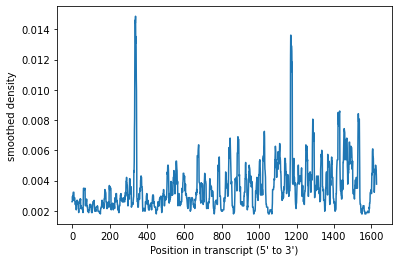

In [184]:
%matplotlib inline
plt.plot(pbar)
plt.ylabel('smoothed density')
plt.xlabel("Position in transcript (5' to 3')")

## Deconvolution 
Ok, lets just try to create A. So I have my list of lambda... have you even considered that perhaps the fact that it is lambda bar and not lambda prime is not a mistake? 

nvm, so I have a list of codons, and if I read through those codons in batches of ten along the codon sequence I will get 10* lambda prime. So, for each lambda prime, I need to know...
ok wait. The thing I do not know is the thing in the center which is what I am deconvolving for. So I have my list of lambdas b just like I used to do it, and then I have a matrix that, for each set of 10 codons along the entire sequence, says wether or not the codon appears in that set of 10. 

#### Questions:
If a certain codon shows up more than once in a set of 10 codons, then should we count that codon twice? Like, are there any 2s in this matrix? Some As have more 

Bigger questions, does the order these are in matter? I guess they do because it will effect the order that B is in, but still it feels a bit arbitrary... maybe it is a bit arbitrary.

In [185]:
A = np.zeros((len(lbar),64))

In [186]:
for row, i in zip(A, range(len(A))):
    set_of_10 = codon_seq_list[index][i:i+10]
    for j in set_of_10:
        row[j] = 1

In [187]:
b = 10*lbar

In [188]:
ls_result = lsqr(A,b)

In [189]:
Ci = ls_result[0]

In [190]:
tau = Ci.mean()
prod_r = 1/tau

In [191]:
# Computing the unscaled rates
elongation = lbar/tau
termination = sc_term/tau # This makes no sense, it always ends up being huge... maybe it is just len(p)/M?
initiation = sc_init/tau

In [193]:
initiation

0.0023472931896431253

In [161]:
with open(save_path + 'lost_gene_test_chi.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(np.atleast_2d(elongation).T)

Text(0, 0.5, 'Ribosome counts')

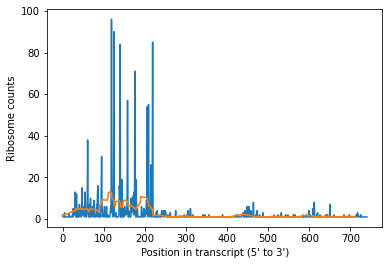

In [102]:
# 30-codon sliding window average
window = np.ones(30).astype(float)/30.0
sliding_window_avg = np.convolve(my_vector,window,mode="valid")


# plot
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(my_vector,label="%s counts" % my_transcript.get_name())
plt.plot(sliding_window_avg,label="30 codon average")
plt.xlabel("Position in transcript (5' to 3')")
plt.ylabel("Ribosome counts")

# add outlines at start & stop codons
#plt.axvline(my_transcript.cds_start,color="#999999",dashes=[3,2],zorder=-1)
#plt.axvline(my_transcript.cds_end,color="#999999",dashes=[3,2],zorder=-1)